# Investigating Tree Canopy Inequity In Vancouver, British Columbia
Group 50: Paul English, Zhuoran Wang, Junyao Wang, Halley Suarez, Eric Shuai

<h2 style="color:#008a05">Introduction</h2>

Urban tree cover provides a variety of ecosystem services beyond aesthetic benefits. These include a reduced heat island effect through shading, increased air quality, and reduced stormwater flooding  [(McDonald et. al. 2021)](https://doi.org/10.1371/journal.pone.0249715). Larger trees are better equipped to provide these ecosystem services as they have greater structural complexity and a more developed canopy [(Baró et. al., 2019)](https://www.sciencedirect.com/science/article/pii/S0169204620314766). Thus, urban tree cover is an integral piece of life in a city environment, yet there are many areas in and around Vancouver that exhibit little to no tree cover at all. 
<br>This phenomenon is known as **tree canopy inequity**, where low-income and minority neighbourhoods tend to have less tree cover and fewer large trees than wealthier and non-minority neighbourhoods. This has been observed in cities across Canada [(Kiani et. al., 2023)](https://doi.org/10.1016/j.landurbplan.2023.104871).

In this study, wealth is analyzed in the Greater Vancouver Area to see if high-income neighbourhoods correlate to having more trees as well as bigger trees. This study plans to investigate if there is a positive association between income and mean tree diameter in Vancouver to test if tree canopy inequity is present. Additionally, the standard deviation of tree diameter will be explored to quantify the observed variation in tree size.

**Question:** Does there exist a positive association between the wealthiness of a neighbourhood and the corresponding mean tree diameter in that community for the Greater Vancouver Area?

<h2 style="color:#008a05">Methods</h2>

INCOME DATA IS FROM 2015. TREE DATA IDK. DIAMETER IS IN WHAT UNITS?

**<u>Variables used:</u>**

> **Danceability**, `danceability` (0.0-1.0, no units)
>
> **Energy**, `energy` (0.0-1.0, no units)
>
> **Tempo**, `tempo` (dbl, BPM)
>
> **Valence/musical positiveness**, `valence` (0.0-1.0)
>
> **Modality**, `mode` (0.0-1.0)

We will be using the energy, valence, tempo, and mode as predictor variables. Energy and tempo are crucial as they form the rhythmic backbones of a song’s danceability. The valence and mode were selected as a song expressing higher positiveness may influence the listener to dance along, or if the switch of mode can affect the feeling towards a song.

After completing initial cleanup (trimming `N/A` values, selecting, etc.), we first need to proportionally sample the data since the dataset is too large, before splitting it into training/testing data. Next, we perform rectangular k-neighbours regression analysis alongside cross-validation to determine an optimal number of neighbours, $k$, before trying our model against testing data to determine model accuracy. We can then plot multiple scatter plots with danceability against each predictor with the training model average as a line, and a line graph revealing the RMSE against multiple values of $k$.

Finally, we would like to repeat our analysis through linear regression, allowing us to compare the accuracies of both models.


<h2 style="color:#008a05">Preliminary Exploratory Data Analysis</h2>

### Loading Libraries, Reading Data

In [52]:
# --- Setting up prerequisites libraries ---
library(tidyverse)
library(tidymodels)
# library(broom)
library(repr)
# library(digest)
library(infer)
# library(gridExtra)
options(repr.matrix.max.rows = 8)

In [2]:
# --- Load data from the web  ---
# load data about all trees in Vancouver
street_trees <- read_delim(url("https://github.com/eshuaiii/stat-201-2023w1-group-50/raw/main/streettrees.csv"), delim=";")

# load income data in Vancouver
area_profiles <- read_csv(url("https://github.com/eshuaiii/stat-201-2023w1-group-50/raw/main/AreaProfiles.csv"), skip = 4)

# The census data contains much more information than we need, with each info point as a row.
# Hence, we'll slice only the average income field (at row 1882) from the dataset
average_income <- slice(area_profiles, 1882)

# Preview the data
head(street_trees, 3)
average_income

Rows: 150695 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr  (15): STD_STREET, GENUS_NAME, SPECIES_NAME, CULTIVAR_NAME, COMMON_NAME,...
dbl   (5): TREE_ID, CIVIC_NUMBER, ON_STREET_BLOCK, HEIGHT_RANGE_ID, DIAMETER
date  (1): DATE_PLANTED

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 5589 Columns: 26
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Variable
dbl  (1): ID
num (24): Arbutus-Ridge, Downtown, Dunbar-Southlands, Fairview, Grandview-Wo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TREE_ID,CIVIC_NUMBER,STD_STREET,GENUS_NAME,SPECIES_NAME,CULTIVAR_NAME,COMMON_NAME,ASSIGNED,ROOT_BARRIER,PLANT_AREA,⋯,ON_STREET,NEIGHBOURHOOD_NAME,STREET_SIDE_NAME,HEIGHT_RANGE_ID,HEIGHT_RANGE,DIAMETER,CURB,DATE_PLANTED,Geom,geo_point_2d
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<date>,<chr>,<chr>
5791,3708,W 35TH AV,PSEUDOTSUGA,MENZIESII,NA,DOUGLAS FIR,N,N,L,⋯,W 35TH AV,DUNBAR-SOUTHLANDS,EVEN,9,90' - 100',50.00,Y,NA,"{""coordinates"": [-123.186767, 49.240027], ""type"": ""Point""}","49.240027, -123.186767"
5797,1101,E 7TH AV,ACER,PLATANOIDES,NA,NORWAY MAPLE,Y,N,N,⋯,E 7TH AV,MOUNT PLEASANT,ODD,2,20' - 30',8.25,Y,NA,"{""coordinates"": [-123.080395, 49.264375], ""type"": ""Point""}","49.264375, -123.080395"
5798,1101,E 7TH AV,ACER,PLATANOIDES,NA,NORWAY MAPLE,Y,N,N,⋯,E 7TH AV,MOUNT PLEASANT,ODD,3,30' - 40',12.25,Y,NA,"{""coordinates"": [-123.080284, 49.264372], ""type"": ""Point""}","49.264372, -123.080284"


ID,Variable,Arbutus-Ridge,Downtown,Dunbar-Southlands,Fairview,Grandview-Woodland,Hastings-Sunrise,Kensington-Cedar Cottage,Kerrisdale,⋯,Riley Park,Shaughnessy,South Cambie,Strathcona,Sunset,Victoria-Fraserview,West End,West Point Grey,Vancouver CSD,Vancouver CMA
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1858,Average total income in 2015 among recipients ($),62675,63251,78117,61627,42896,38258,38411,77248,⋯,53060,118668,65459,31534,34212,34298,47253,82042,50317,46821


### Sampling and creating tidy data

In [29]:
# Remove unnecessary columns and remove any data points from trees that have an NA value for diameter
street_trees_cleaned <- street_trees |>
    select(TREE_ID, COMMON_NAME, NEIGHBOURHOOD_NAME, DIAMETER) |>
    filter(!is.na(DIAMETER))

# Also rename all column names to be lowercase
names(street_trees_cleaned) <- tolower(names(street_trees_cleaned))

head(street_trees_cleaned)

tree_id,common_name,neighbourhood_name,diameter
<dbl>,<chr>,<chr>,<dbl>
5791,DOUGLAS FIR,DUNBAR-SOUTHLANDS,50.00
5797,NORWAY MAPLE,MOUNT PLEASANT,8.25
5798,NORWAY MAPLE,MOUNT PLEASANT,12.25
5799,NORWAY MAPLE,MOUNT PLEASANT,9.50
5800,NORWAY MAPLE,MOUNT PLEASANT,20.00
5802,NORWAY MAPLE,MOUNT PLEASANT,18.00


***Note:** Because the `street_trees` dataset contains well over 150k points, we will sample 50k points instead due to limitations of hardware. We will discuss the implications of this in our Discussion.*

In [33]:
# Setting our seed once
set.seed(50)

# taking a sample of 50k points from the trees dataset
trees <- street_trees_cleaned |>
    sample_n(50000)

Next, we'll clean up our `average_income` dataset, modifying it into a long format. We will also remove the `Variable` and `ID` columns as they give technical information, and will also remove the `Vancouver CSD` and `Vancouver CMA` columns as they are summaries of regions (`Vancouver CSD` is the census sub-division, i.e. the city of Vancouver, and `Vancouver CMA` is the metropolitian area).

In [38]:
# Lengthening the dataset and removing unnecessary columns
income <- average_income |>
    select(-Variable, -ID, -"Vancouver CSD", -"Vancouver CMA") |>
    pivot_longer(cols = everything(), names_to = "location", values_to = "avg_income")
    # arrange(avg_income) # sort income in ascending order
income

location,avg_income
<chr>,<dbl>
Arbutus-Ridge,62675
Downtown,63251
Dunbar-Southlands,78117
Fairview,61627
⋮,⋮
Sunset,34212
Victoria-Fraserview,34298
West End,47253
West Point Grey,82042


For consistency, we will also modify all neighbourhood names in the `trees` dataset to match those of the `average_income` dataset.

In [37]:
# Rename all locations in the `trees` dataset to match the `income` dataset
trees$neighbourhood_name[trees$neighbourhood_name == "ARBUTUS RIDGE"]<- "Arbutus-Ridge"
trees$neighbourhood_name[trees$neighbourhood_name == "DOWNTOWN"]<- "Downtown"
trees$neighbourhood_name[trees$neighbourhood_name == "DUNBAR-SOUTHLANDS"]<- "Dunbar-Southlands"
trees$neighbourhood_name[trees$neighbourhood_name == "FAIRVIEW"]<- "Fairview"
trees$neighbourhood_name[trees$neighbourhood_name == "GRANDVIEW-WOODLAND"]<- "Grandview-Woodland"
trees$neighbourhood_name[trees$neighbourhood_name == "HASTINGS-SUNRISE"]<- "Hastings-Sunrise"
trees$neighbourhood_name[trees$neighbourhood_name == "KENSINGTON-CEDAR COTTAGE"]<- "Kensington-Cedar Cottage"
trees$neighbourhood_name[trees$neighbourhood_name == "KERRISDALE"]<- "Kerrisdale"
trees$neighbourhood_name[trees$neighbourhood_name == "KILLARNEY"]<- "Killarney"
trees$neighbourhood_name[trees$neighbourhood_name == "KITSILANO"]<- "Kitsilano"
trees$neighbourhood_name[trees$neighbourhood_name == "MARPOLE"]<- "Marpole"
trees$neighbourhood_name[trees$neighbourhood_name == "MOUNT PLEASANT"]<- "Mount Pleasant"
trees$neighbourhood_name[trees$neighbourhood_name == "OAKRIDGE"]<- "Oakridge"
trees$neighbourhood_name[trees$neighbourhood_name == "RENFREW-COLLINGWOOD"]<- "Renfrew-Collingwood"
trees$neighbourhood_name[trees$neighbourhood_name == "RILEY PARK"]<- "Riley Park"
trees$neighbourhood_name[trees$neighbourhood_name == "SHAUGHNESSY"]<- "Shaughnessy"
trees$neighbourhood_name[trees$neighbourhood_name == "SOUTH CAMBIE"]<- "South Cambie"
trees$neighbourhood_name[trees$neighbourhood_name == "STRATHCONA"]<- "Strathcona"
trees$neighbourhood_name[trees$neighbourhood_name == "SUNSET"]<- "Sunset"
trees$neighbourhood_name[trees$neighbourhood_name == "VICTORIA-FRASERVIEW"]<- "Victoria-Fraserview"
trees$neighbourhood_name[trees$neighbourhood_name == "WEST END"]<- "West End"
trees$neighbourhood_name[trees$neighbourhood_name == "WEST POINT GREY"]<- "West Point Grey"

Below is a list of the region names:

In [39]:
income$location

[1] "Arbutus-Ridge"            "Downtown"                
 [3] "Dunbar-Southlands"        "Fairview"                
 [5] "Grandview-Woodland"       "Hastings-Sunrise"        
 [7] "Kensington-Cedar Cottage" "Kerrisdale"              
 [9] "Killarney"                "Kitsilano"               
[11] "Marpole"                  "Mount Pleasant"          
[13] "Oakridge"                 "Renfrew-Collingwood"     
[15] "Riley Park"               "Shaughnessy"             
[17] "South Cambie"             "Strathcona"              
[19] "Sunset"                   "Victoria-Fraserview"     
[21] "West End"                 "West Point Grey"

###  Statistical Summary

In [48]:
# --- Summarizing `trees` ---
# summarizing per region
trees_summary_region <- trees |>
    group_by(neighbourhood_name) |>
    summarize(n = n(),
              mean_diameter = mean(diameter),
              sd_diameter = sd(diameter))

# override row limit just for this cell
options(repr.matrix.max.rows = Inf)
trees_summary_region
options(repr.matrix.max.rows = 8)

# for fun, find overall mean and sd
trees_summary_entire <- trees |>
    summarize(n = n(),
              mean_diameter = mean(diameter),
              sd_diameter = sd(diameter))

trees_summary_entire

neighbourhood_name,n,mean_diameter,sd_diameter
<chr>,<int>,<dbl>,<dbl>
Arbutus-Ridge,1768,12.007489,8.755964
Downtown,1666,8.109934,5.838565
Dunbar-Southlands,3199,14.619772,10.775832
Fairview,1401,11.629122,8.419905
Grandview-Woodland,2389,12.809125,9.425282
Hastings-Sunrise,3601,11.785948,8.895578
Kensington-Cedar Cottage,3800,11.805989,9.090078
Kerrisdale,2277,12.818226,10.304073
Killarney,2200,10.004209,7.317172


n,mean_diameter,sd_diameter
<int>,<dbl>,<dbl>
50000,11.91723,9.297665


In [51]:
# --- Summarizing `income` ---

# producing the average income in all regions, again, bypassing max rows
options(repr.matrix.max.rows = Inf)
income
options(repr.matrix.max.rows = 8)

# just for fun, find average income
income_average <- income |>
    summarize(average = mean(avg_income)) |>
    pull()
income_average

location,avg_income
<chr>,<dbl>
Arbutus-Ridge,62675
Downtown,63251
Dunbar-Southlands,78117
Fairview,61627
Grandview-Woodland,42896
Hastings-Sunrise,38258
Kensington-Cedar Cottage,38411
Kerrisdale,77248
Killarney,39013


[1] 54739.5

### General Visualizations

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



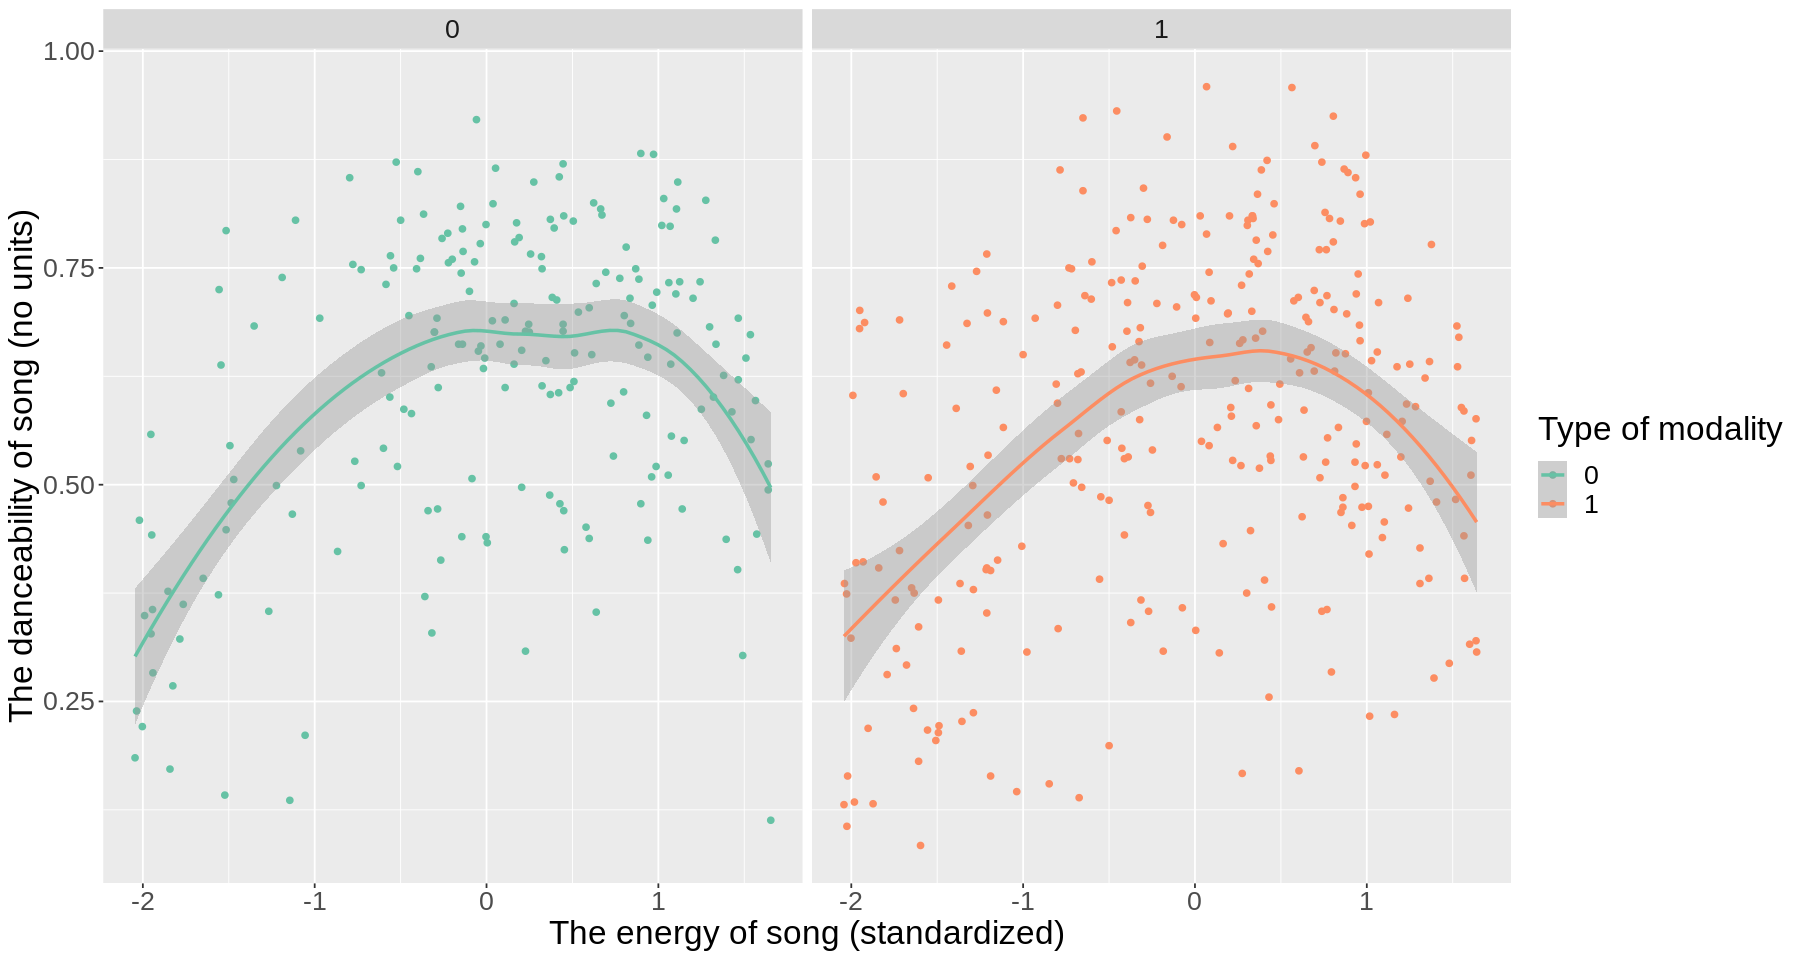

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



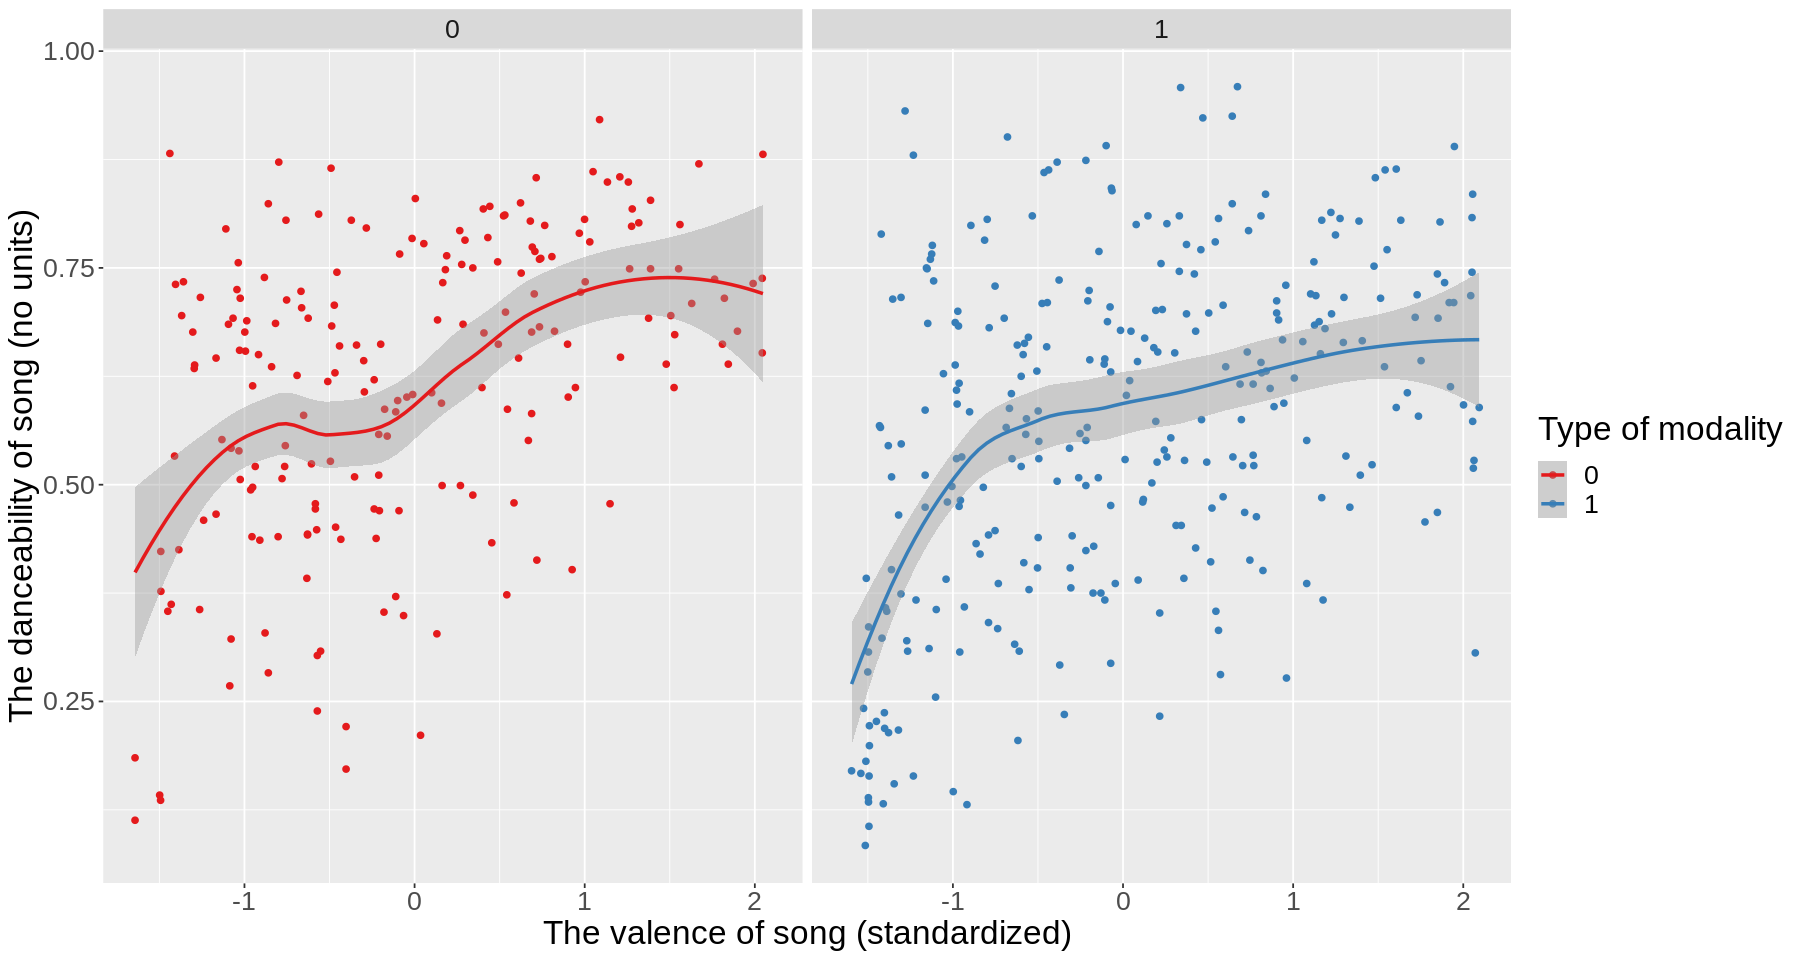

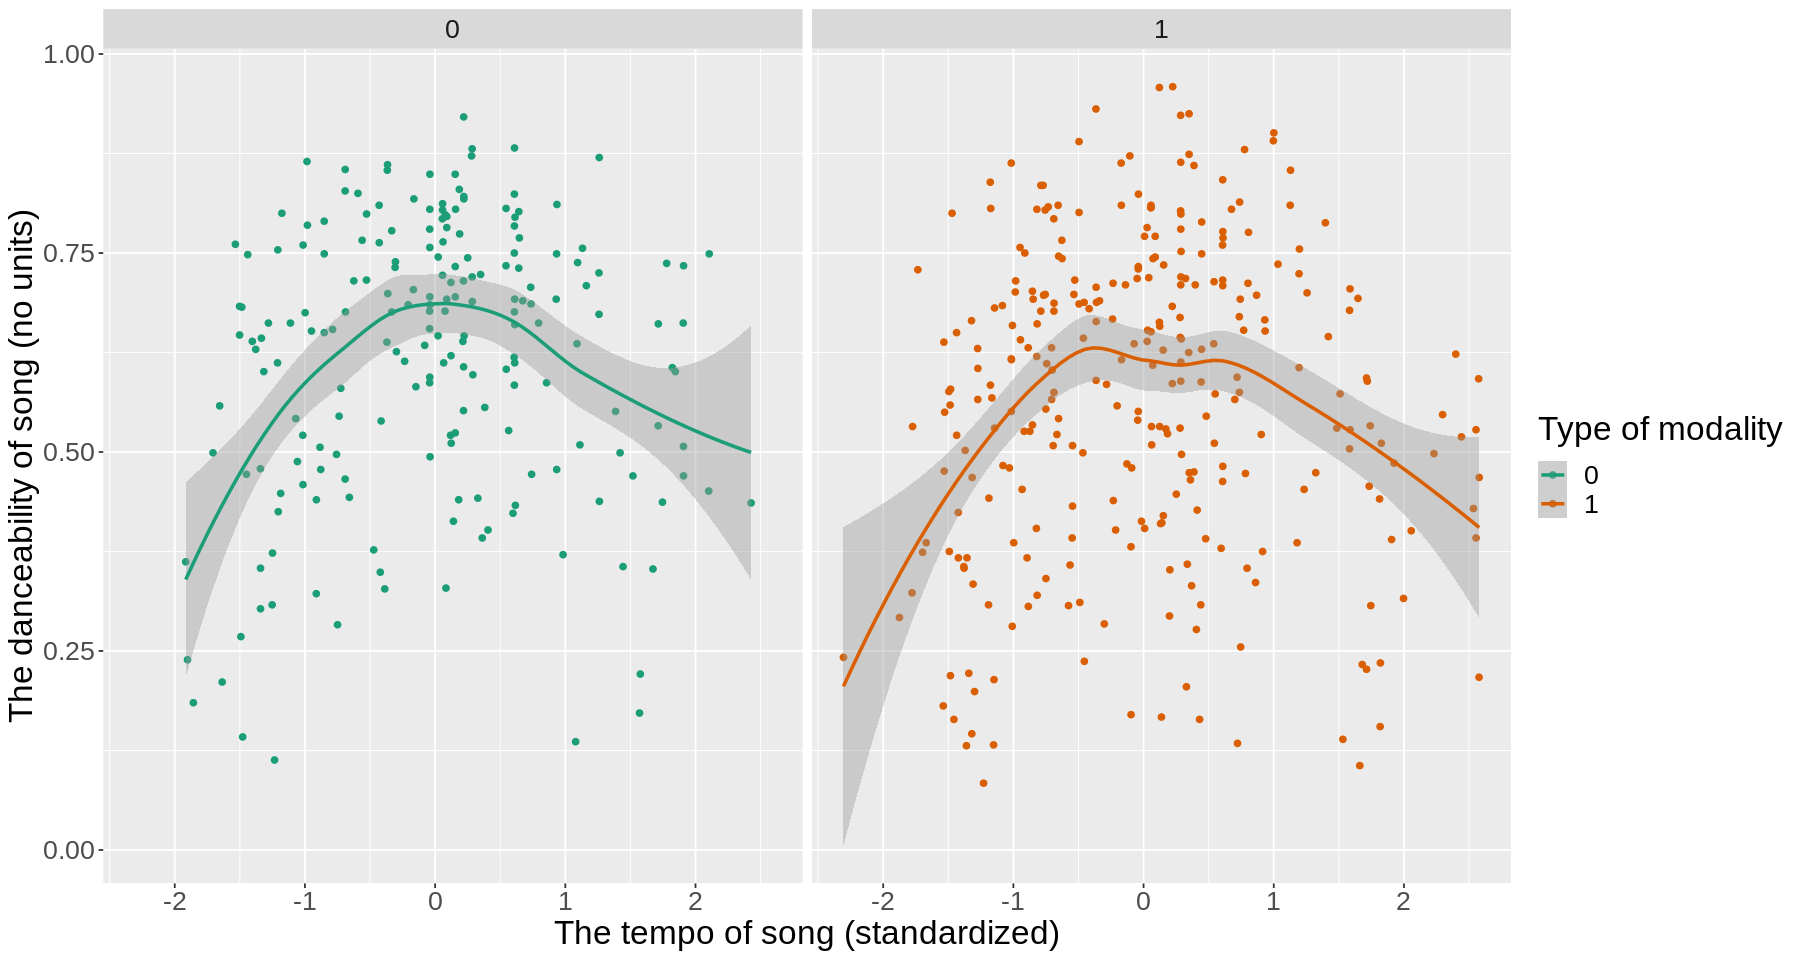

In [6]:
options(repr.plot.width = 15, repr.plot.height = 8)

# Visualize the average income of each neighbourhood

# Visualize the mean and spread of average tree diameter for each neighbourhood

#
# Visualize the relationship between danceability and energy, classified by mode
ggplot(spotify_training, aes(x = energy, y = danceability, color = mode)) +
    geom_point(alpha = 1.1) +
    geom_smooth()+
    facet_wrap(~mode) +
    labs(x = "The energy of song (standardized)", y = "The danceability of song (no units)", color = "Type of modality") +
    theme(text = element_text(size = 20)) +
    scale_color_brewer(palette = "Set2")

# Visualize the relationship between danceability and valence, classified by mode
ggplot(spotify_training, aes(x = valence, y = danceability, color = mode)) +
    geom_point(alpha = 1.1) +
    geom_smooth()+
    facet_wrap(~mode) +
    labs(x = "The valence of song (standardized)", y = "The danceability of song (no units)", color = "Type of modality") +
    theme(text = element_text(size = 20)) +
    scale_color_brewer(palette = "Set1")

# Visualize the relationship between danceability and tempo, classified by mode
ggplot(spotify_training, aes(x = tempo, y = danceability, color = mode)) +
    geom_point(alpha = 1.1) +
    geom_smooth()+
    facet_wrap(~mode) +
    labs(x = "The tempo of song (standardized)", y = "The danceability of song (no units)", color = "Type of modality") +
    theme(text = element_text(size = 20)) +
    scale_color_brewer(palette = "Dark2")

filter out the average income for each location in Vancouver

In [4]:
areaavgincome <- AreaProfiles_averageincome %>% group_by(Variable) %>% summarize(mean = mean(Arbutus.Ridge:Vancouver.CMA))%>%
filter(Variable =="Avg_income")
areaavgincome


Variable,mean
<chr>,<dbl>
Avg_income,54748


table1.3

Calculate out the total average income among all locations.

In [5]:
lowincomearea <- final_Areaincome %>% filter(Avg_income < 54748.0)%>% select(Location,Avg_income)
Highincomearea <- final_Areaincome %>% filter(Avg_income >= 54748.0)%>% select(Location,Avg_income)

Filter out the low income area and high income area by comparing each income to the total average income

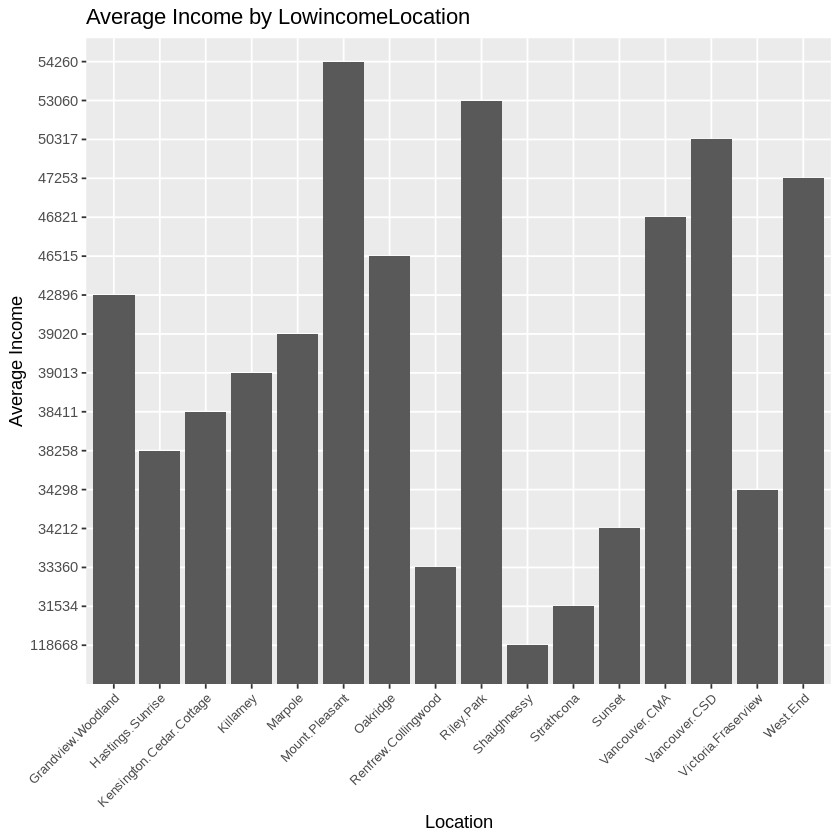

In [6]:
lowincomearea_plot<- lowincomearea %>% ggplot(aes(x=Location, y= Avg_income))+ geom_bar(stat="identity") +
labs(title="Average Income by LowincomeLocation",
       x="Location",
       y="Average Income") +theme(axis.text.x = element_text(size=8, angle=45, hjust=1))
lowincomearea_plot

graph1.1

the visualization of income in each low income location

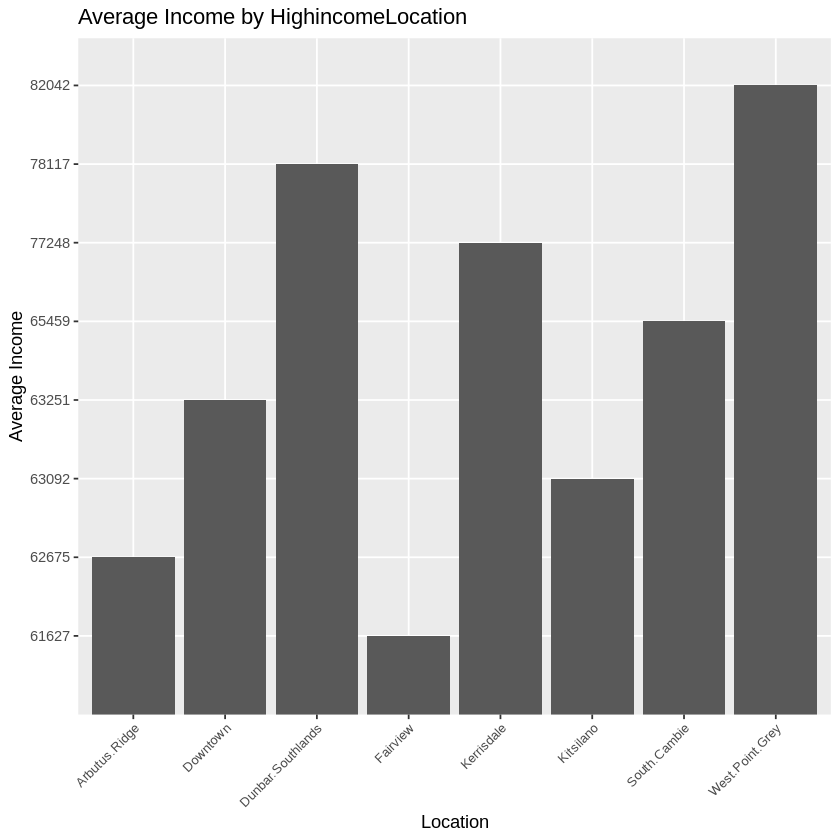

In [7]:
Highincomearea_plot<- Highincomearea %>% ggplot(aes(x=Location, y= Avg_income))+ geom_bar(stat="identity") +
labs(title="Average Income by HighincomeLocation",
       x="Location",
       y="Average Income") +theme(axis.text.x = element_text(size=8, angle=45, hjust=1))
Highincomearea_plot

graph1.2

the visualization of income in each High income location

In [9]:
dinhigh <- AreatreeDiameter %>% filter(NEIGHBOURHOOD_NAME %in% Highincomearea$Location)
dinlow <- AreatreeDiameter %>% filter(NEIGHBOURHOOD_NAME %in% lowincomearea$Location)

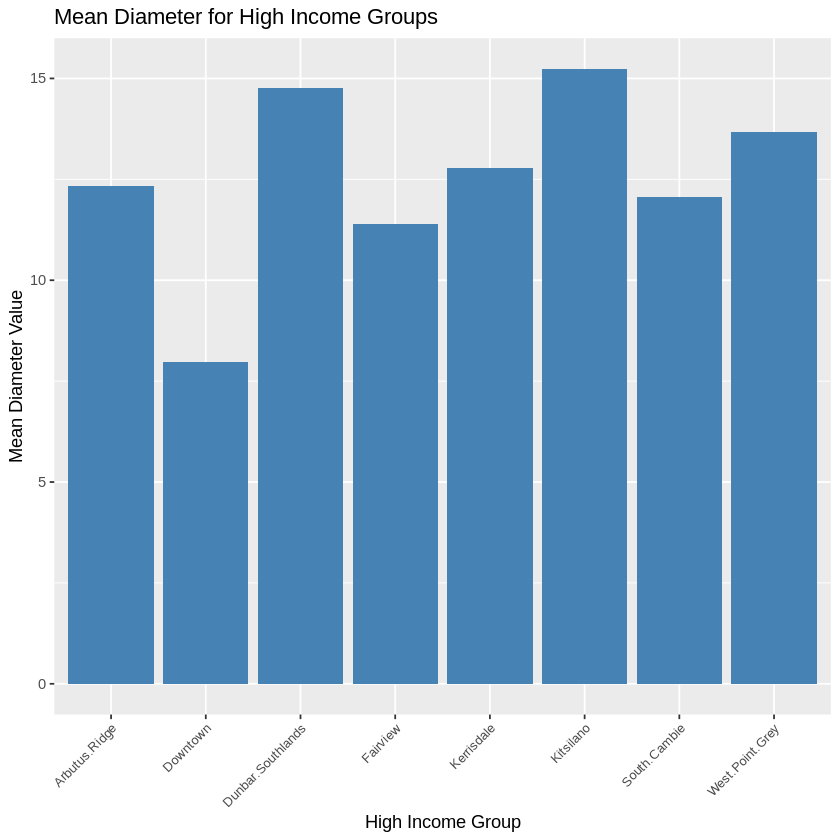

In [10]:
mean_for_eachhigh <- dinhigh %>% group_by(NEIGHBOURHOOD_NAME) %>% summarize(mean = mean(DIAMETER))
mean_for_eachhigh_plot <- mean_for_eachhigh %>% ggplot(aes(x=NEIGHBOURHOOD_NAME, y=mean))+ 
geom_bar(stat="identity", fill="steelblue")+
labs(title="Mean Diameter for High Income Groups", y="Mean Diameter Value", x="High Income Group")+
theme(axis.text.x = element_text(size=8, angle=45, hjust=1))
mean_for_eachhigh_plot

graph1.3

Mean Tree Diameter among High Income Locations

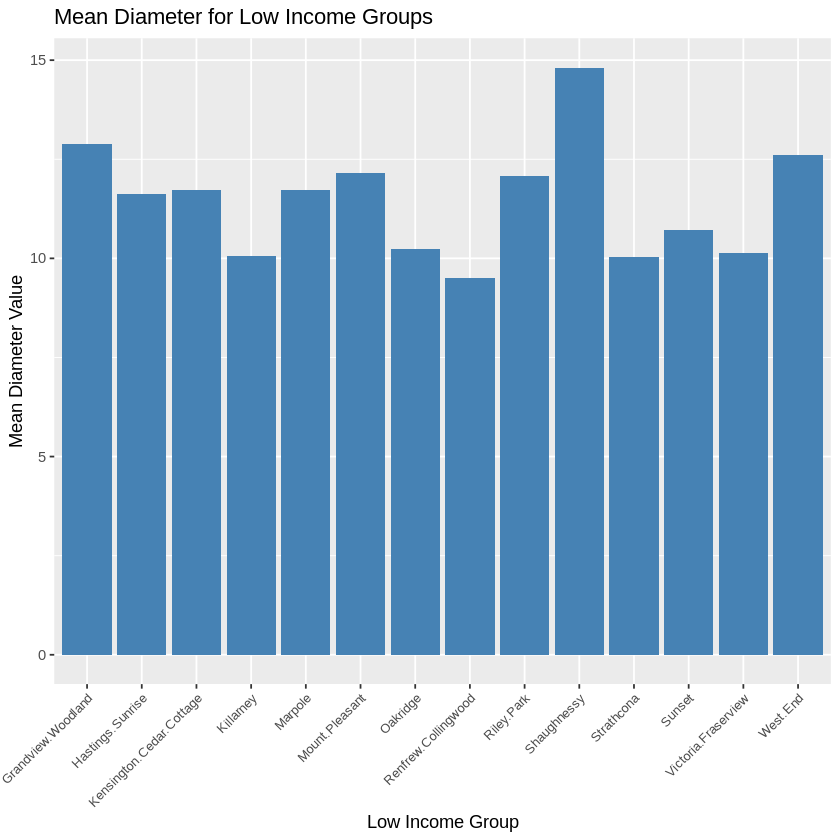

In [11]:
mean_for_eachlow <- dinlow %>% group_by(NEIGHBOURHOOD_NAME) %>% summarize(mean = mean(DIAMETER))
mean_for_eachlow_plot <- mean_for_eachlow %>% ggplot(aes(x=NEIGHBOURHOOD_NAME, y=mean))+ 
geom_bar(stat="identity", fill="steelblue")+
labs(title="Mean Diameter for Low Income Groups", y="Mean Diameter Value", x="Low Income Group")+
theme(axis.text.x = element_text(size=8, angle=45, hjust=1))
mean_for_eachlow_plot

graph1.4

Mean Tree Diameter among Lower Income Locations

In [15]:

mean_d_inhigh <- mean(dinhigh$DIAMETER)
mean_d_inlow <- mean(dinlow$DIAMETER)
mean_f <- data.frame(Mean_For_Low = c(mean_d_inlow), Mean_For_High = c(mean_d_inhigh))
mean_f

Mean_For_Low,Mean_For_High
<dbl>,<dbl>
11.40866,12.9423


In [ ]:
table1.4

In [ ]:
The mean of tree diamters in all low income area and high income area

In [16]:
bootstrapforhigh <- dinhigh %>% rep_sample_n(size=20, reps=1000, replace= TRUE)%>% group_by(replicate) %>% summarize(mean = mean(DIAMETER))
bootstrapfordlow <- dinlow %>% rep_sample_n(size=20, reps=1000, replace= TRUE)%>% group_by(replicate) %>% summarize(mean_for_low = mean(DIAMETER))
bootstrapdifmean <- bootstrapfordlow %>% mutate(mean_for_high = bootstrapforhigh$mean, dif_in_mean = bootstrapforhigh$mean - mean_for_low)


In [ ]:
bootstrapdifmean_plot <- bootstrapdifmean %>% ggplot() + 
    geom_histogram(aes(dif_in_mean, y = ..density..), color='red', binwidth=.05) + 
    theme(text = element_text(size=10)) +
    xlab("the difference in diameter") +
    ggtitle("the bootstrapped distribution for difference of tree diameter in high and low income area")
bootstrapdifmean_plot

<h2 style="color:#008a05">Expected Outcomes and Significance</h2>

We expect that an appropriate model will be developed to incorporate our predictor variables—valence, mode, tempo, and energy—to predict the danceability of an unknown song. The results of this study could assist musicians who desire to create danceable music according to specific characteristics. This finding could assist them in identifying and selecting danceable features of the song before creating it, thus increasing the likelihood of a successful composition.

Further, this study raises several interesting questions. For instance:
- How do other variables, like a song’s length, its key, or how wordy it is, affect its danceability?
- Is popularity based primarily on how danceable a song is?
- Since the danceability variable, per Spotify, is a combination of factors like beat strength, regularity, and stability, is it an unbiased, objective variable?
- Could the danceability of a song be viewed differently across regions, cultures, and societies?

<br><br><br>
*Thank you! - Group 79*